## Training
Prepapre dataset with the prepare_dataset notebook, before running this one.

In [1]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from time import time, sleep
import numpy as np
import os
import warnings; warnings.filterwarnings("ignore")
from utils import *
  
# DEV = torch.device(CPU) # for debugging, use cpu
os.makedirs(f"{SAVE_DIR}", exist_ok=True)
print(f'DEV: {DEV}, has_screen: {LOCAL}, job id: {JOBID}')

# copy the python training to the directory (for cluster) (for local, it fails silently)
os.system(f"cp train.py {SAVE_DIR}/train.py")
os.system(f"cp utils.py {SAVE_DIR}/utils.py")

# SMALL, NORM, BIG = "small", "norm", "big"

Running JOBID: local, on cpu
DEV: cpu, has_screen: True, job id: local


cp: cannot stat 'train.py': No such file or directory


0

In [ ]:
EPOCHS = 12 if LOCAL else 100 # number of epochs 20 <-
# BATCH_SIZE = 128 # 128 
BATCH_SIZE = 4 if LOCAL else 64 # 64 <-

# LOAD_PRETRAINED = f'{BEST_MODEL_DIR}/best_{FX}.pth' if LOCAL else None # pretrained model
LOAD_PRETRAINED = None # Set it to None if you don't want to load pretrained model

In [3]:
# schedulers
from numpy import concatenate as cat, linspace as linsp, logspace as logsp
### learning rate
# LR = 3e-4*logsp(0, -2, EPOCHS) 
# LR = 3e-3*np.ones(EPOCHS) 
# LR = 3e-3*logsp(0, -2, EPOCHS)  
LR = 1e-3*logsp(0, -2, EPOCHS) # <-
# LR = 3e-3*np.ones(EPOCHS) 

### loss ratios 

# ## gso
# # RGSO = cat((linsp(1e-6, 3e-3, EPOCHS//2), linsp(3e-3, 0.0, EPOCHS//2))) 
# MAX_GSO = 3e-3 # 3e-3 <-
# # RGSO = cat((linsp(1e-6*MAX_GSO, MAX_GSO, EPOCHS//4), 
# #             linsp(MAX_GSO, MAX_GSO, EPOCHS//4), 
# #             linsp(MAX_GSO, 0.0, EPOCHS//4), 
# #             linsp(0.0, 0.0, EPOCHS//4))) #
# # RGSO = cat((MAX_GSO*logsp(-6, 0, EPOCHS//4), 
# #                           MAX_GSO*logsp(0, 0, EPOCHS//4), 
# #                           MAX_GSO*logsp(0, -10, EPOCHS//4), 
# #                           logsp(-12, -12, EPOCHS//4))) 
# RGSO = np.zeros(EPOCHS) # <- # for now gso disbled is better, probably redundant with y2

## Fx
MAX_R_FX = 1.0 # 0.5 <-
R_FX = MAX_R_FX * np.ones(EPOCHS) 
# R_FX = cat((np.ones(3*EPOCHS//4)*MAX_R_FX, np.zeros(EPOCHS//4))) #
#             linsp(MAX_R_FX, MAX_R_FX, EPOCHS//4), 
#             linsp(MAX_R_FX, 0.0, EPOCHS//4), 
# R_FX = MAX_R_FX * logsp(0, -2, EPOCHS) # <-
# R_FX = MAX_R_FX * logsp(0, -3, EPOCHS) 

## Iy
MAX_R_IY = 1e-5 # 0.05 <-
# R_IY = MAX_R_IY * np.ones(EPOCHS)
# R_IY  = MAX_R_IY * logsp(0, -2, EPOCHS) 
# R_IY  = MAX_R_IY * logsp(0, -3, EPOCHS) 
R_IY  = MAX_R_IY * logsp(0, -4, EPOCHS) # <-
# R_IY = np.zeros(EPOCHS)
# R_IY = cat((linsp(1e-6*MAX_R_IY, MAX_R_IY, EPOCHS//4),
#             linsp(MAX_R_IY, MAX_R_IY, EPOCHS//4), 
#             linsp(MAX_R_IY, 0.0, EPOCHS//4), 
#             linsp(0.0, 0.0, EPOCHS//4))) 

## Br Bz
MAX_R_BRZ = 1.0 # 1.0 <-
# R_BRZ = MAX_R_BRZ * np.ones(EPOCHS)
# R_BRZ = cat((np.zeros(EPOCHS//4),
#          MAX_R_BRZ*np.ones(3*EPOCHS//4))) 
R_BRZ = np.ones(EPOCHS) * MAX_R_BRZ # <-

## LCFS/Sep
MAX_R_SEP = 1e-2 # 1.0 <-
# R_SEP = MAX_R_SEP * np.ones(EPOCHS)
# R_SEP = cat((np.zeros(EPOCHS//4),
#          MAX_R_SEP*np.ones(3*EPOCHS//4))) 
# R_SEP = np.ones(EPOCHS) * MAX_R_SEP 
# R_SEP = MAX_R_SEP * logsp(0, -3, EPOCHS) 
R_SEP = MAX_R_SEP * logsp(0, -4, EPOCHS) # <-

In [4]:
#checks
if LOAD_PRETRAINED is not None: assert os.path.exists(LOAD_PRETRAINED), "Pretrained model does not exist"
assert os.path.exists(TRAIN_DS_PATH), "Training dataset does not exist"
assert os.path.exists(EVAL_DS_PATH), "Evaluation dataset does not exist"
assert os.path.exists(SAVE_DIR), "Save directory does not exist"
assert len(LR) == EPOCHS, "Learning rate array length does not match epochs"
# assert len(RGSO) == EPOCHS, "GSO loss ratio array length does not match epochs"
assert len(R_FX) == EPOCHS, "R_FX loss ratio array length does not match epochs"
assert len(R_IY) == EPOCHS, "R_IY loss ratio array length does not match epochs"
assert len(R_BRZ) == EPOCHS, "R_BRZ loss ratio array length does not match epochs"
assert len(R_SEP) == EPOCHS, "R_SEP loss ratio array length does not match epochs"

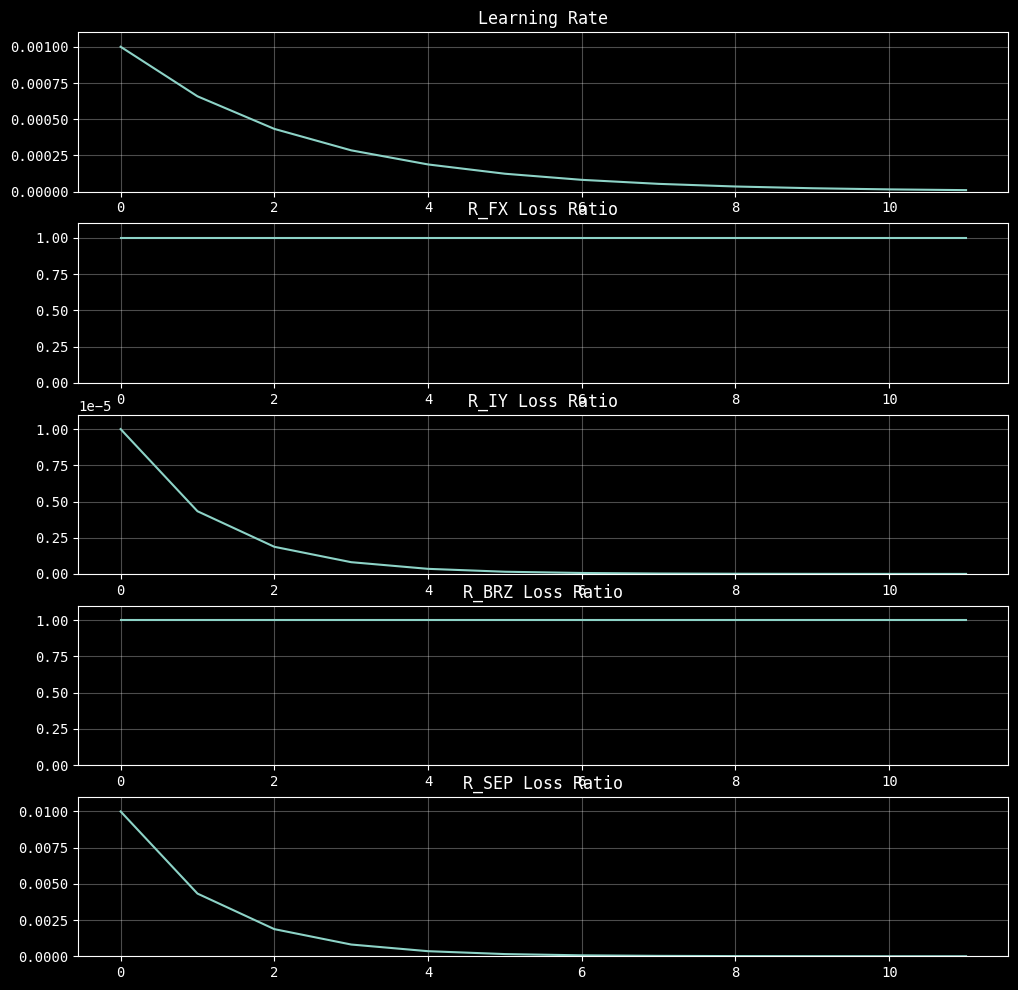

In [5]:
# plot schedulers
plt.figure(figsize=(12, 12))
plt.subplot(5, 1, 1)
plt.plot(LR)
plt.ylim(0, np.max(LR)*1.1)
plt.title('Learning Rate')
plt.subplot(5, 1, 2)
plt.plot(R_FX)
plt.ylim(0, np.max(R_FX)*1.1)
plt.title('R_FX Loss Ratio')
plt.subplot(5, 1, 3)
plt.plot(R_IY)
plt.ylim(0, np.max(R_IY)*1.1)
plt.title('R_IY Loss Ratio')
plt.subplot(5, 1, 4)
plt.plot(R_BRZ)
plt.ylim(0, np.max(R_BRZ)*1.1)
plt.title('R_BRZ Loss Ratio')
plt.subplot(5, 1, 5)
plt.plot(R_SEP)
plt.ylim(0, np.max(R_SEP)*1.1)
plt.title('R_SEP Loss Ratio')
plt.show() if LOCAL else plt.savefig(f"{SAVE_DIR}/schedulers.png")

Dataset loaded from dss/train_ds.npz, keys: dict_keys(['phys', 'pts', 'Fx', 'Iy', 'Br', 'Bz', 'sep'])
Dataset: N:800, memory:20.4608MB, on_dev:False
Dataset loaded from dss/eval_ds.npz, keys: dict_keys(['phys', 'pts', 'Fx', 'Iy', 'Br', 'Bz', 'sep'])
Dataset: N:200, memory:5.1152MB, on_dev:False
test_dataset
Dataset length: 200
Inputs: X -> torch.Size([136]), r -> torch.Size([1000, 2]), z -> torch.Size([1000])
Outputs: Y1 -> torch.Size([1000]), Y2 -> torch.Size([1000]), Y3 -> torch.Size([1000])
200


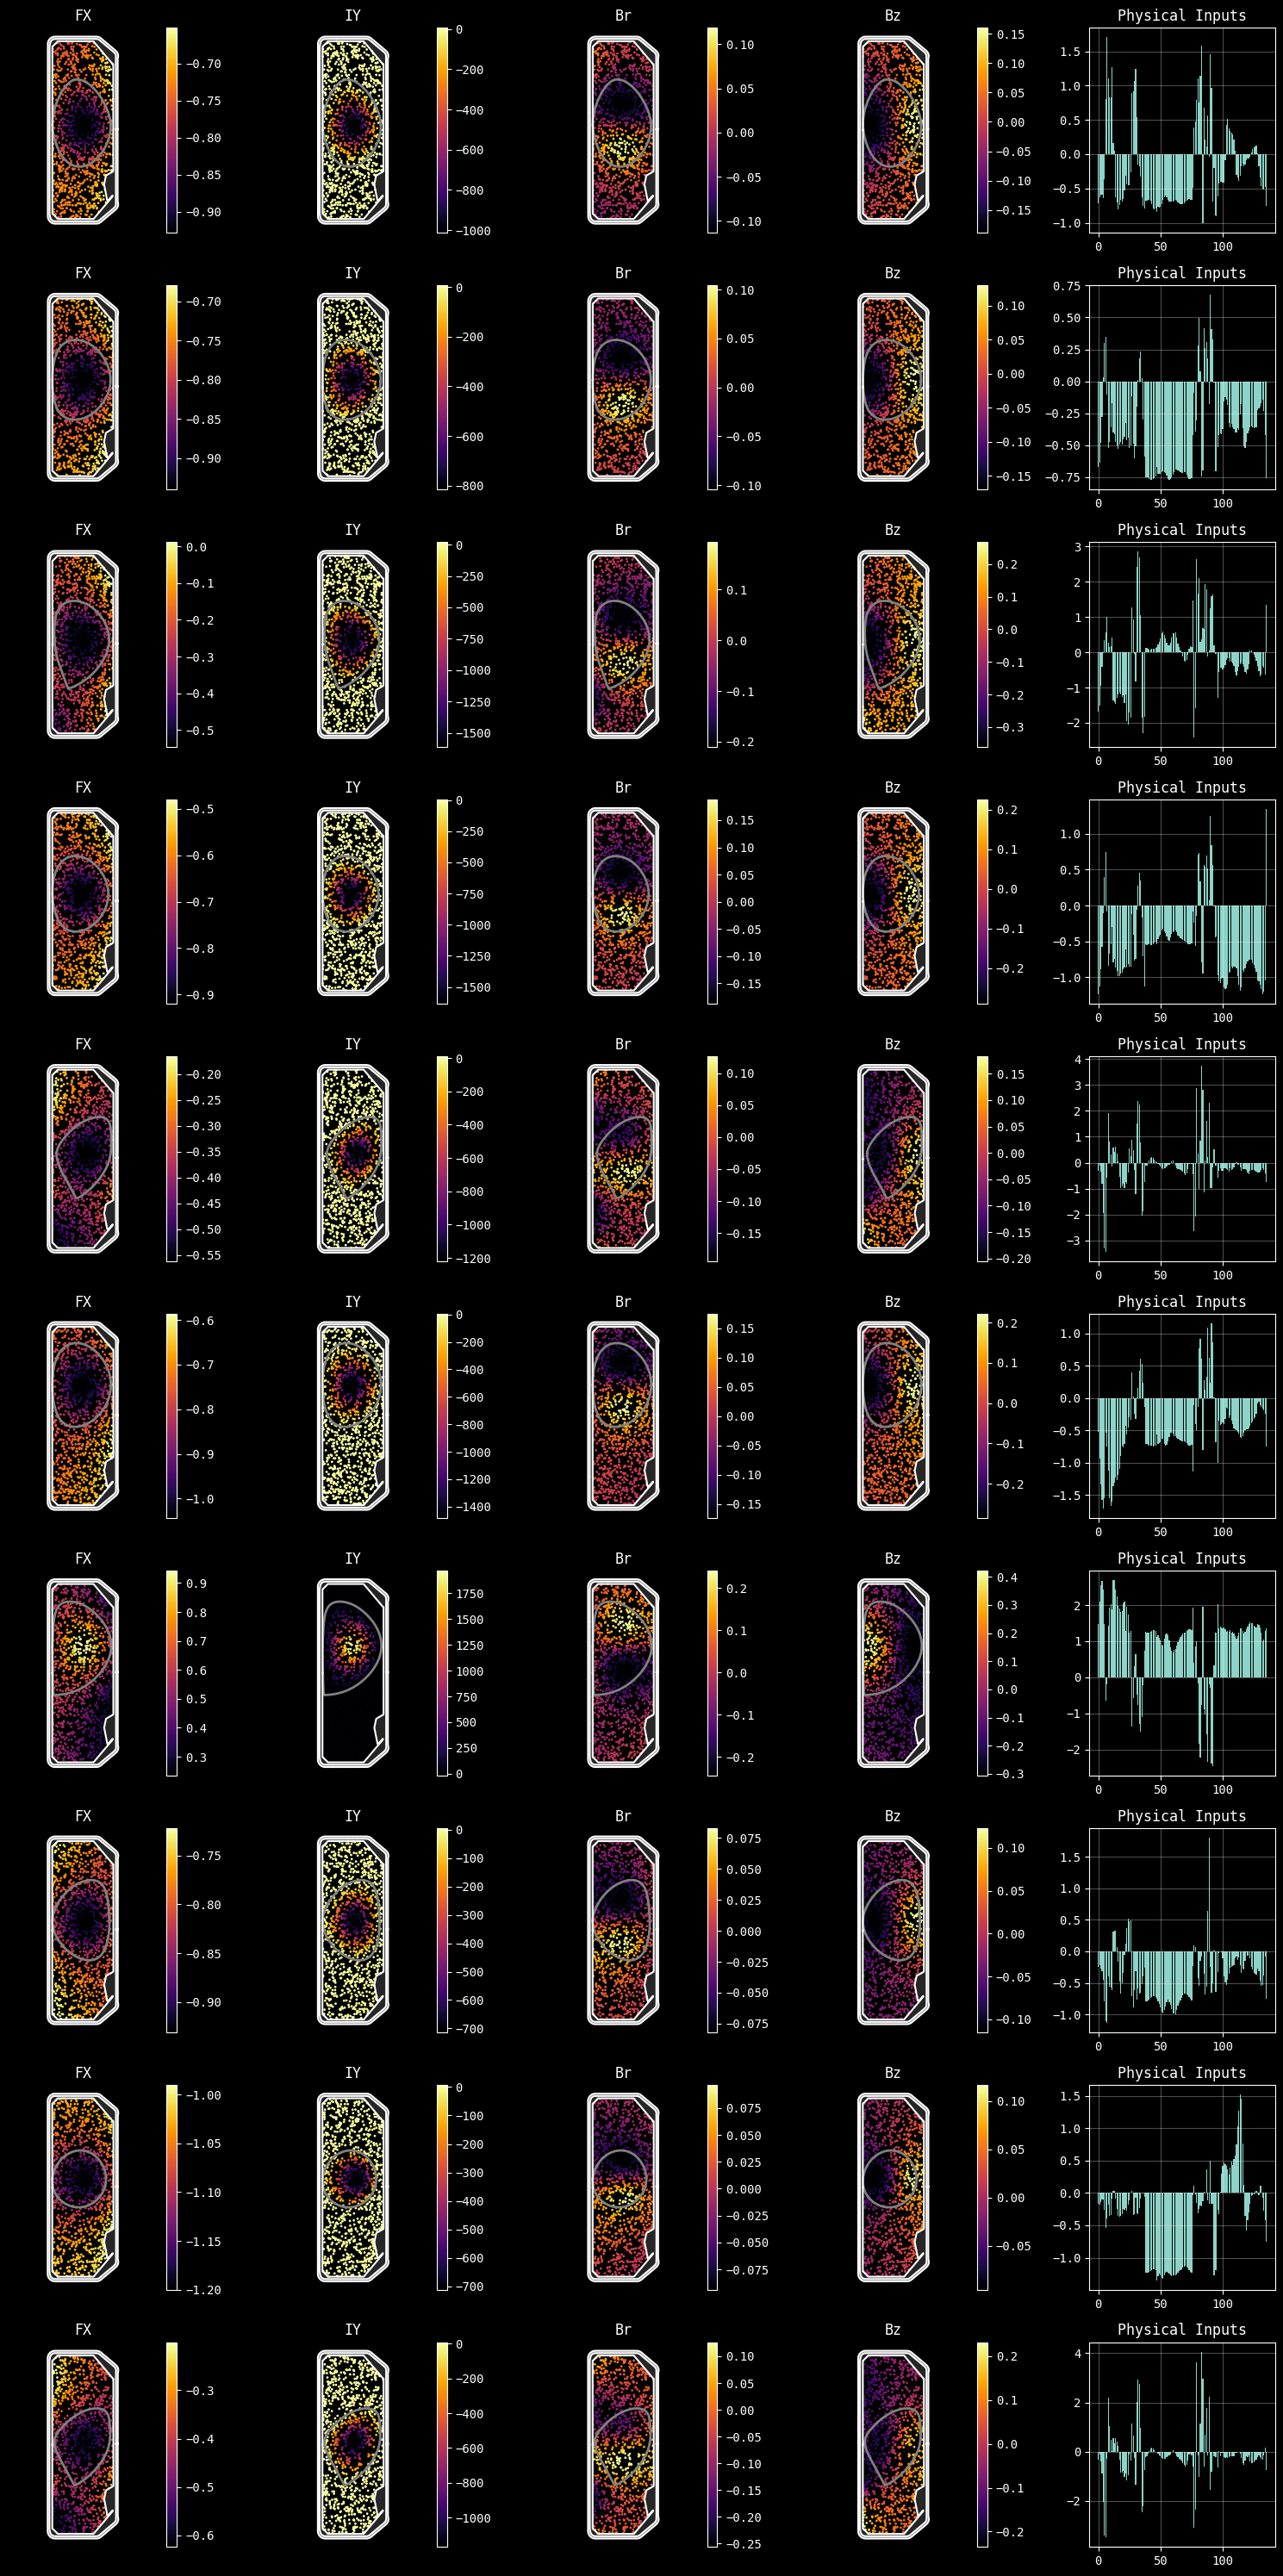

In [6]:
# create training and evaluation datasets
train_ds = LiuqeDataset(TRAIN_DS_PATH)
val_ds = LiuqeDataset(EVAL_DS_PATH)
test_dataset(val_ds)
#save the mean_std of the dataset int the save directory
np.savez(f"{SAVE_DIR}/x_mean_std.npz", x_mean_std=train_ds.x_mean_std.cpu().numpy())

In [7]:
# test net I/O
test_network_io()

test_network_io
single FullNet -> in: [torch.Size([1, 136]), torch.Size([1, 5, 2])], 
            out: [torch.Size([1, 5, 3]), torch.Size([1, 5]), torch.Size([1, 258])]
single LiuqeRTNet  -> in: [torch.Size([1, 136]), torch.Size([1, 5, 2])], 
            out: [torch.Size([5, 3])]
batched FullNet -> in: [torch.Size([7, 136]), torch.Size([7, 5, 2])], 
            out: [torch.Size([7, 5, 3]), torch.Size([7, 5]), torch.Size([7, 258])]


## Training

In [ ]:
def train():
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
    # network
    model = FullNet(InputNet(train_ds.x_mean_std), PtsEncoder(), FHead(3), FHead(1), LCFSHead())
    opt = torch.optim.Adam(model.parameters(), lr=LR[0])
    if LOAD_PRETRAINED is not None: # load pretrained model
        model.load_state_dict(torch.load(LOAD_PRETRAINED, map_location=torch.device(CPU)), strict=STRICT_LOAD) # load pretrained model
        print(f"Pretrained model loaded: {LOAD_PRETRAINED}")
    model.to(DEV) # move model to DEV
    loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
    tlog, elog = np.inf*np.ones((EPOCHS, len(train_dl), len(LOSS_NAMES))), np.inf*np.ones((EPOCHS, len(val_dl), len(LOSS_NAMES))) # init log
    start_time = time() # start time
    print("Ep:    || fx  | iy  | br  | bz  | sep || r:fx| r:iy|r:brz|r:sep| LR  || t  | eta| improved    ")
    for ep in range(EPOCHS): # epochs
        epoch_time = time()
        for pg in opt.param_groups: pg['lr'] = LR[ep] # update learning rate
        model.train()
        for ib, batch in enumerate(train_dl):
            if train_ds.on_dev: x, p, fx, iy, br, bz, sep = batch # unpack batch
            else: x, p, fx, iy, br, bz, sep = map(lambda t: t.to(DEV), batch) # move to DEV
            opt.zero_grad() # zero gradients
            rtp, iyp, sepp = model(x, p) # forward pass
            fxp, brp, bzp = rtp[:,:,0], rtp[:,:,1], rtp[:,:,2] # unpack outputs
            # gso, gsop = calc_gso_batch(y1, r, z, dev=DEV), calc_gso_batch(yp1, r, z, dev=DEV) # calculate grad shafranov
            # losses
            l_fx = loss_fn(fx, fxp) # fx loss
            l_iy = loss_fn(iy, iyp) # iy loss
            l_br = loss_fn(br, brp) # br loss
            l_bz = loss_fn(bz, bzp) # bz loss
            l_sep = loss_fn(sep, sepp) # lcfs loss
            # lgso = loss_fn(gsop, gso) # PINN loss on grad shafranov
            loss = R_FX[ep]*l_fx + R_IY[ep]*l_iy + R_BRZ[ep]*l_br + R_BRZ[ep]*l_bz + R_SEP[ep]*l_sep#+ RGSO[ep]*lgso # total loss
            loss.backward() # backprop
            opt.step() # update weights
            tlog[ep, ib] = (l_fx.item(), l_iy.item(), l_br.item(), l_bz.item(), l_sep.item()) # save batch losses
        model.eval() # evaluation mode
        with torch.no_grad():
            for ib, batch in enumerate(val_dl):
                if val_ds.on_dev: x, p, fx, iy, br, bz, sep = batch # unpack batch
                else: x, p, fx, iy, br, bz, sep = map(lambda t: t.to(DEV), batch) # move to DEV
                rtp, iyp, sepp = model(x, p) # forward pass
                fxp, brp, bzp = rtp[:,:,0], rtp[:,:,1], rtp[:,:,2]
                # losses
                l_fx = loss_fn(fx, fxp) # fx loss
                l_iy = loss_fn(iy, iyp) # iy loss
                l_br = loss_fn(br, brp) # br loss
                l_bz = loss_fn(bz, bzp) # bz loss
                l_sep = loss_fn(sep, sepp) # lcfs loss
                # lgso = loss_fn(gsop, gso) # PINN loss on grad shafranov
                assert not torch.isnan(l_fx) and not torch.isnan(l_iy) and not torch.isnan(l_br) and not torch.isnan(l_sep), "Loss is NaN"
                elog[ep, ib] = (l_fx.item(), l_iy.item(), l_br.item(), l_bz.item(), l_sep.item())
        # save model if improved        
        endp = "" 
        epoch_losses = np.mean(elog[ep,:,:], axis=0) # epoch losses: mean across batchess
        best_losses = np.min(np.mean(elog[:ep,:,:], axis=1), axis=0) if ep > 0 else epoch_losses # best losses: min across epochs
        for el, bl, n in zip(epoch_losses, best_losses, LOSS_NAMES):
            if el <= bl: torch.save(model.state_dict(), model_path(n)); endp+=f"*{n}"
        # print progress
        print(f"{ep+1:03d}/{EPOCHS:02d}||" +
            '|'.join([f"{v:.0e}" for v in epoch_losses]) + "||" +
            f"{R_FX[ep]:.0e}|{R_IY[ep]:.0e}|{R_BRZ[ep]:.0e}|{R_SEP[ep]:.0e}|{LR[ep]:.0e}||" +
            f"{int(time()-epoch_time):03d}s|{int((time()-start_time)*(EPOCHS-ep)/(ep+1)/60):03d}m|", end=endp+'\n')
        if ep >= 10 and best_losses[2] > 0.1: return False 

    tlosses, elosses = np.mean(tlog, axis=1), np.mean(elog, axis=1) # losses across epochs
    print(f"Training time: {(time()-start_time)/60:.0f}mins")
    print("Best losses  : " + ", ".join([f"{n} {bl:.3e} (ep {be})" for n, bl, be in zip(LOSS_NAMES, np.min(elosses, axis=0), np.argmin(elosses, axis=0))]))
    print("Estimated MAE: " + ", ".join([f"{n} {np.sqrt(np.min(np.mean(elog[:,:,i], axis=1))):.3e}" for i, n in enumerate(LOSS_NAMES)]))
    np.save(f"{SAVE_DIR}/train_losses.npy", tlosses) # save training losses
    np.save(f"{SAVE_DIR}/eval_losses.npy", elosses) # save evaluation losses
    return True

# train the model (multiple attempts)
for i in range(20): 
    print('Starting training...')
    success = train()
    if success: break
    else: print(f"Convergence failed, retrying... {i+1}/20")
# if not success: delete the files and exit:
if not success: os.system(f"rm -rf {SAVE_DIR}")
assert success, "Training failed, no model saved"

Starting training...
Ep:    || fx  | iy  | br  | bz  | sep || r:fx| r:iy|r:brz|r:sep| LR  || t  | eta| improved    
001/12||1e-01|9e+04|4e-03|7e-03|1e-02||1e+00|1e-05|1e+00|1e-02|1e-03||003s|000m|*Fx*Iy*Br*Bz*sep
002/12||9e-02|9e+04|4e-03|6e-03|1e-02||1e+00|4e-06|1e+00|4e-03|7e-04||004s|000m|*Fx*Iy*Br*Bz
003/12||6e-02|9e+04|3e-03|5e-03|1e-02||1e+00|2e-06|1e+00|2e-03|4e-04||003s|000m|*Fx*Iy*Br*Bz*sep
004/12||5e-02|9e+04|3e-03|5e-03|1e-02||1e+00|8e-07|1e+00|8e-04|3e-04||003s|000m|*Fx*Iy*Br*Bz*sep


In [ ]:
# plot losses
print("Plotting losses...")
fig, ax = plt.subplots(2, len(LOSS_NAMES), figsize=(4*len(LOSS_NAMES), 8))
# Load losses
train_loss = np.load(f"{SAVE_DIR}/train_losses.npy")
eval_loss = np.load(f"{SAVE_DIR}/eval_losses.npy")
for i, name in enumerate(LOSS_NAMES):
    # Linear scale
    ax[0,i].plot(train_loss[:,i], label='train')# y1_mean_std = np.concatenate([μy1, Σy1], axis=0)
# y2_mean_std = np.concatenate([μy2, Σy2], axis=0)
    ax[0,i].plot(eval_loss[:,i], label='eval')
    ax[0,i].set_title(f"{name}")
    ax[0,i].set_xlabel("Epoch")
    ax[0,i].set_ylabel("Loss")
    ax[0,i].legend(); ax[0,i].grid(True)
    # Log scale
    ax[1,i].plot(train_loss[:,i], label='train')
    ax[1,i].plot(eval_loss[:,i], label='eval')
    ax[1,i].set_yscale('log')
    ax[1,i].set_title(f"{name} (log)")
    ax[1,i].set_xlabel("Epoch")
    ax[1,i].set_ylabel("Loss")
    ax[1,i].legend(); ax[1,i].grid(True)
plt.tight_layout()
plt.show() if LOCAL else plt.savefig(f"{SAVE_DIR}/losses.png")

In [ ]:
# testing network outputs
try:
# if True:
    print("Testing network output...")
    for ln in LOSS_NAMES:
        model = FullNet(InputNet(train_ds.x_mean_std), PtsEncoder(), FHead(3), FHead(1), LCFSHead())
        model.load_state_dict(torch.load(model_path(ln), map_location=torch.device(CPU))) # load pretrained model
        plot_network_outputs(val_ds, model, title=ln) # plot network outputs  
except Exception as e:
    print(f"Error in testing network output: {e}")
    print("Skipping network output testing...")
    pass

In [ ]:
# test LCFS net (not the target anymore)
try:
    m = FullNet(InputNet(train_ds.x_mean_std), PtsEncoder(), FHead(3), FHead(1), LCFSHead())
    m.load_state_dict(torch.load(model_path(SEP), map_location=torch.device(CPU))) # load pretrained model
    lcfs = LCFSNet(m.input_net, m.lcfs_head)
    plot_lcfs_net_out(val_ds, lcfs, title='') # plot LCFS net outputs
except Exception as e:
    print(f"Error in testing LCFS net: {e}")
    print("Skipping LCFS net testing...")
    pass

In [ ]:
# convert best LiuqRTNet network to ONNX
try: 
    # raise NotImplementedError("ONNX conversion is not implemented yet") 
    print("Converting best l_br network to ONNX...")
    m = FullNet(InputNet(train_ds.x_mean_std), PtsEncoder(), FHead(3), FHead(1), LCFSHead())
    m.load_state_dict(torch.load(model_path(FX), map_location=torch.device(CPU))) # load pretrained model
    net = LiuqeRTNet(m.input_net, m.pts_enc, m.rt_head) # create LiuqeRTNet
    try: convert_to_onnx_dyn(net) # dynamic axes
    # try: convert_to_onnx_static(net) # static axes
    except Exception as e: print(f"Error exporting to ONNX: {e}")
except Exception as e:
    print(f"Error in ONNX conversion: {e}")
    print("ONNX conversion failed")
    pass

In [ ]:
print(f"{JOBID} done")
if not LOCAL: sleep(30) # wait for files to update (for cluster)
#copy the log file to the folder
os.system(f"cp jobs/{JOBID}.txt {SAVE_DIR}/log.txt")